# First Order PV Filtering

### Problem statement
Design a first order filter for an analog continuous signal commonly known as Process Value (PV).

### Assumptions
<ol>
    <li> A 'first order' filter implies that there is one pole to place in the theoretical transfer function for the system. This could act in one of two ways:
        <ul>
            <li>LOW PASS - attenuating information above a certain cutoff frequency</li>
            <li>HIGH PASS - attenuating information below a certaing cutoff frequency</li>
        </ul>
    </li>
    <li>This said, given the PV is very likely a low frequency signal, and a 'first order filter' is usually just referring to a low pass filter, the digital filter in this case will be configured to <b>only</b> provide low pass filtering capabilities.</li>
    <li>While the PV may be a continuous signal, we are assuming here that it is sampled in a discrete fashion. As such, the filter is designed as a discrete filter to emulate the characteristics of it's continuous counterpart.</li>
</ol>

In [8]:
import numpy as np
import matplotlib.pyplot as plt

### Process Variable design
The Process Variable in this case is defined as the state of a linear time invariant (LTI) system with second order dynamics.  The system is governed by the set of ordinary differential equations

$$
\dot{x_1} = x_2\\
\dot{x_2} = -w_n^2 x_1 - 2\zeta w_n x_2 + u
$$

The variables $\zeta$ (damping ratio) and $w_n$ (natural frequency) can be adjusted to simulate different dynamics. One typical physical manifestation of this system may be a mechanical spring-mass-damper where $x_1$ is the displacement and $x_2$ is the velocity of the mass. The control input to the system is $u$, which would be an analog for acceleration or force applied to the mass in the spring-mass-damper scenario.

By adjusting the damping ratio, you can illicit:
<ul>
    <li> overdamped behviour with $\zeta > 1$,</li>
    <li> critically damped behaviour when $\zeta = 1$, and</li>
    <li> under damped behaviour when $0 < \zeta < 1$.</li>
</ul>
    
The natural frequncy, $w_n$, controls the frequency by which the system oscillates. A higher frequency leads to more oscillations during a shorter window of time.

The initial state of the system of the is defined in a 2x1 vector, with the first entry being the observed state (e.g. displacement) and the second entry the first derivative (e.g. velocity).
    
After initial conditions are configured on instantiation, control inputs can be passed through the `step` function to move the process around. The controller gain is set to one and not configurable in this simulation.
    
Noise is added to the output of the system, configurable with the sigma variable that sets the standard deviation for a zero-mean Gaussian noise (higher the sigma, higher the amplitude of the noise).



In [9]:
class process_variable(object):
    """
    A simulated process variable (PV).
    
    Defined as a linear time invariant (LTI) system with second order dynamics.
    Zeta and wn (natural frequency) can be adjusted to simulate different
    dynamics.
    
    After initial conditions are configured on instantiation, control inputs 
    can be passed through the step() function to move the process around. Noise
    is added to the output of the system, configurable with the sigma variable.
    """
    def __init__(self, zeta, wn, x_0, u_0, dt, sigma):
        """
        Parameters
        ----------
        zeta : float
            Damping factor.
                - overdamped -> zeta > 1
                - critically damped -> zeta = 1
                - under damped -> 0 < zeta < 1
        wn : float
            Natural frequency. The larger the number, the faster the system
            oscillates in time.
        x_0 : np.array([float])
            Initial state. 2x1 numpy vector. First entry is zeroeth order state
            variable (e.g. displacement), second entry is the first order
            state variable (e.g. velocity).
        u_0 : float
            Control input. No gain configurable gain in this system so the 
            response is 1-to-1.
        dt : float
            Time constant. Time lapse between discrete samples of the system.
        sigma : float
            Noise standard deviation. Std dev of measurement noise.

        Returns
        -------
        None.

        """
        # initial conditions
        self.x = x_0
        self.u = u_0
        
        # dynamic and noise variables
        self.wn = wn
        self.sigma = sigma
        
        # initial output
        self.y = np.dot(np.array([wn**2, 0.]),  x_0)
        
        # discretized process model
        self.Ad = np.eye(2) + np.array([[0., 1.], [-(wn**2.), (-2.)*zeta*wn]]) * dt
        self.Bd = np.array([[0.], [1.]]) * dt
        
    def step(self, u):
        """        
        Parameters
        ----------
        u : float
            Control input. 1-to-1 gain, applied to the second order state
            rate of change (e.g. acceleration).

        Returns
        -------
        y : float
            Process output. In this case, defined as the first order state
            variable (e.g. displacement). Gaussian noise is applied with
            standard deviation defined by sigma variable.

        """
        # apply the state update
        self.x = np.dot(self.Ad, self.x) + (self.Bd * u)
        
        # extract the new output
        self.y = np.dot(np.array([self.wn**2, 0.]),  self.x) + np.random.normal(0, self.sigma)
        
        return self.y

### Filter design
The filter is designed with the assumptions stated at the top of the notebook in mind. Since we've assumed that the system is sampled at discrete intervals, this necessitates the design of a discrete filter. A discrete low pass filter is equivalent to an exponentialy weighted moving average. 

The cutoff frequency, $w_c$, determines the frequency above which the signal is attenuated. It is sensible to choose a cutoff frequency lower than that of the noise of the system. Recall that in the process variable class, the noise is injected in each time step, which means that the process measurement noise operates roughly at the frequency $\frac{1}{\Delta t}$. The smoothing factor, $\alpha$, for the exponentially weighted smoothing algorithm is determined as a function of the cutoff frequency and $\Delta t$, 

$$
\alpha = \frac{\Delta t} {(\frac{1}{w_c}) + \Delta t}.
$$

The initial filter state is set on instantiation, and the filter object maintains the state from the previous timestep for the algorithm from then onward. By calling the `filt` function, a new data point in the time sequence can be passed to the filter, with a new filtered state based on that information returned in the function call.

In [10]:
class fo_filter(object):
    """
    A first order low pass filter.
    
    The cutoff frequency is configurable at instantiation.
    
    For a discrete system, a low pass filter is equivalently modelled by an
    exponentially weighted moving average algorithm. The smoothing factor is 
    alpha, calculated by the relationship in the init function.
    """
    def __init__(self, wc, z_0, dt):
        """
        Parameters
        ----------
        wc : float
            Cutoff frequency. Defines the frequency above which the signal is 
            attenuated.
        z_0 : float
            Initial filter state. Initial state of the variable to be filtered.
        dt : float
            Filter time constant. The time lapse between discrete samples of 
            the variable to be filtered. Should be the same as the model.

        Returns
        -------
        None.

        """
        # initialize filter state
        self.z = z_0
        
        # calculate the smoothing factor for the corresponding cutoff frequency
        self.alpha = dt / ((1/wc) + dt)
        
        # step counter
        self.i = 0
        
    def filt(self, data):
        """
        Parameters
        ----------
        data : float
            New data point for the filter. Assumed to be the next piece of
            information passed to the filtering algorithm in the time sequence.

        Returns
        -------
        z : float
            Filtered state. The filtered state after being passed through the
            low-pass algorithm.

        """
        if self.i == 0:
            # skip the first time step, corresponds with the intitial condition
            self.i += 1
        else:
            # apply the exponentially weighted smoothing algorithm
            self.z = self.alpha * data + (1-self.alpha) * self.z
            self.i += 1
        return self.z

### Simulation
First the discrete sampling time constant is set, and a process variable and filter object are instantiated with zeroed initial conditions. The cutoff frequency of the filter is selected to be well below that of the noise frequency.

In [16]:
dt = 0.05
m = process_variable(0.2, 0.7, np.array([[0.], [0.]]), 0., dt, 0.1)
f = fo_filter(2, 0, dt)

A time span is created for the simulation. Then, a series of control inputs are assigned at each timestep. The control inputs undergo a step change from zero to one and then stay there for the remainder of the simulation.

In [17]:
t = np.arange(0, 30, dt)
op = np.where(t < 5, 0, 1)

The control inputs are fed to the state space model and the dynamics are allowed to play out over the time span. The Filter is applied to the noisy system measurements.

In [18]:
pv = np.array([m.step(u) for u in op], dtype=object)
pv_filt = np.array([f.filt(v) for v in pv], dtype=object)

The control input, noisy signal and filtered signal are all plotted over the timespan.

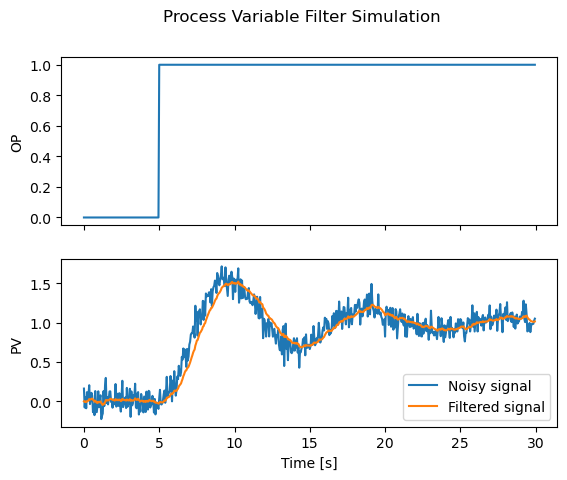

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex='col')
ax1.plot(t, op, label='Control input')
ax1.set_ylabel('OP')
ax2.plot(t, pv, label='Noisy signal')
ax2.plot(t, pv_filt, label='Filtered signal')
fig.suptitle('Process Variable Filter Simulation')
plt.xlabel('Time [s]')
plt.ylabel('PV')
plt.legend()

In [15]:
# clean up
del dt, m, f, t, op, pv, pv_filt